#### Loaded required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_excel('/content/drive/MyDrive/OnlineRetail.xlsx')
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Trying some data attributes

In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 1. Data cleaning


##### Handling missing data

In [6]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Text(0.5, 1.0, 'Percentage of Missing values')

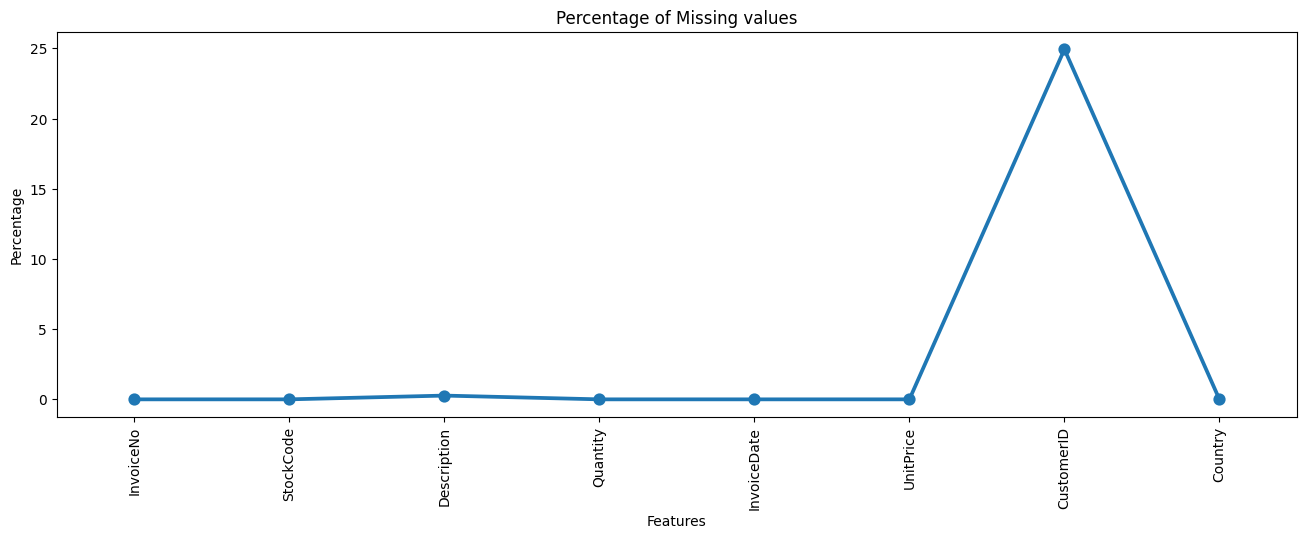

In [7]:
missing_data=pd.DataFrame(((df.isnull().sum())*100)/df.shape[0]).reset_index()

plt.figure(figsize=(16,5))
sns.pointplot(data=missing_data,x='index',y=0)
plt.xticks(rotation=90,fontsize=10)
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.title('Percentage of Missing values')

In [8]:
(df.dropna().shape[0]/df.shape[0])*100

75.0733056657114

In [9]:
df1=df.dropna() #removing entries where customerId and Description having missing values

In [10]:
df1.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


##### Removing duplicate rows

In [11]:
df1.duplicated().sum()

np.int64(5225)

In [12]:
df2 = df1.drop_duplicates(keep='last')

In [13]:
df2.shape

(401604, 8)

##### Removing negative quantities (returns)

In [14]:
df3=df2[df2.Quantity>0]

##### Removing rows with zero or negative price

In [15]:
df3[df3.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


- No entries with UnitPrice negative

##### Convert types

In [16]:
df3['CustomerID']=df3.CustomerID.astype('int')

/tmp/ipython-input-4032244251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['CustomerID']=df3.CustomerID.astype('int')


In [17]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  int64         
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


##### Removing cancellations

In [18]:
df3[df3['InvoiceNo'].astype(str).str.startswith('c')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


- no record with cancellation

## Outlier Detection

In [19]:
df3['Quantity'].describe()

,Quantity
count,392732.000000
mean,13.153718
std,181.588420
min,1.000000
25%,2.000000
50%,6.000000
75%,12.000000
max,80995.000000


- 75% of the records have a quantity less than or equal to 12, huge gap between 75% and max.

In [20]:
df3['UnitPrice'].describe()

,UnitPrice
count,392732.000000
mean,3.125596
std,22.240725
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,8142.750000


- 75% records lies with UnitePrice less than or equal to 3.75 so outliers exist, huge gap between 75% and max.

#### Outliers detection by UnitPrice (75% vs Max)

In [21]:
df5=df3.copy()

In [22]:
product_stats = df5.groupby('Description')['UnitPrice'].describe()
product_stats[['count', 'min', '25%', '50%', '75%', 'max', 'mean', 'std']]

,count,min,25%,50%,75%,max,mean,std
Description,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,37.0,0.79,2.55,2.550,2.55,2.55,2.312162,0.609987
50'S CHRISTMAS GIFT BAG LARGE,109.0,1.04,1.25,1.250,1.25,1.25,1.248073,0.020114
DOLLY GIRL BEAKER,135.0,1.08,1.25,1.250,1.25,1.25,1.243704,0.032225
I LOVE LONDON MINI BACKPACK,69.0,3.75,4.15,4.150,4.15,4.15,4.138406,0.067598
I LOVE LONDON MINI RUCKSACK,1.0,4.15,4.15,4.150,4.15,4.15,4.150000,NaN
...,...,...,...,...,...,...,...,...
ZINC T-LIGHT HOLDER STARS SMALL,238.0,0.72,0.83,0.830,0.83,1.63,0.836975,0.107087
ZINC TOP 2 DOOR WOODEN SHELF,9.0,16.95,16.95,16.950,16.95,16.95,16.950000,0.000000
ZINC WILLIE WINKIE CANDLE STICK,191.0,0.72,0.85,0.850,0.85,1.63,0.872461,0.137740


/tmp/ipython-input-4234083341.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spread = df5.groupby('Description').apply(lambda x: x['UnitPrice'].max() - x['UnitPrice'].quantile(0.75))


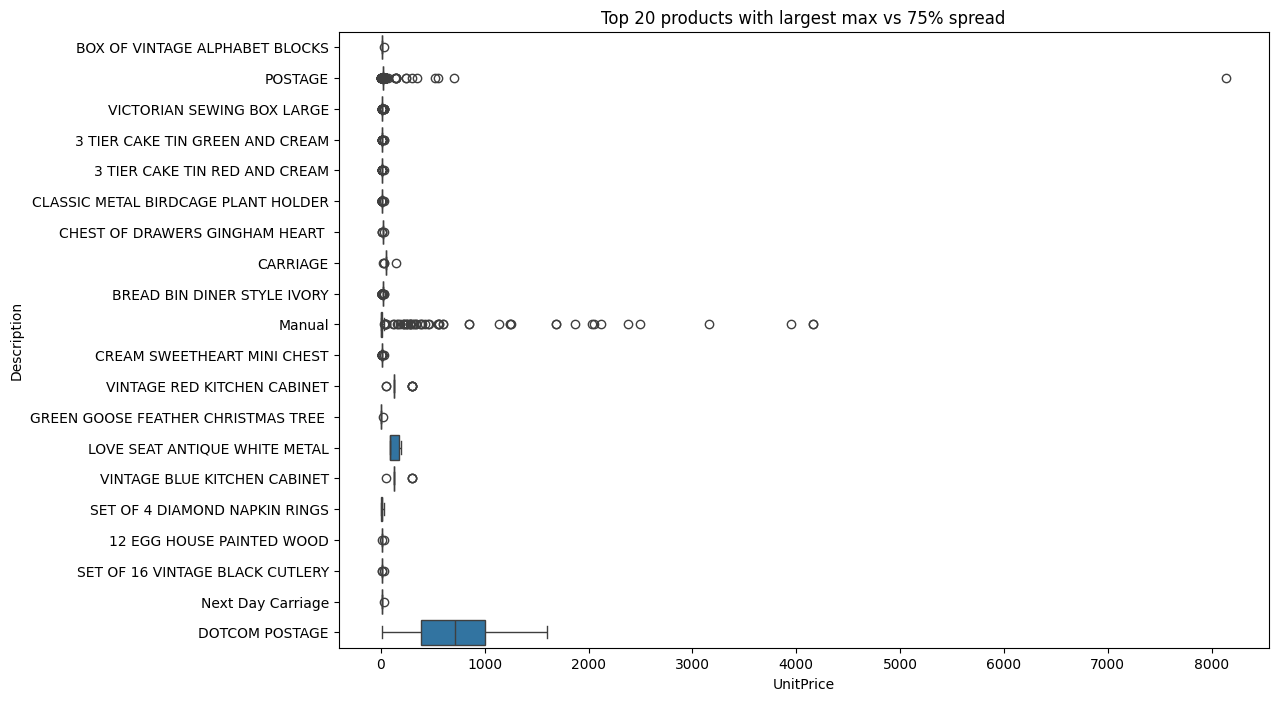

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

spread = df5.groupby('Description').apply(lambda x: x['UnitPrice'].max() - x['UnitPrice'].quantile(0.75))
top_products = spread.sort_values(ascending=False).head(20).index

plt.figure(figsize=(12,8))
sns.boxplot(x='UnitPrice', y='Description', data=df5[df5['Description'].isin(top_products)])
plt.title('Top 20 products with largest max vs 75% spread')
plt.show()


- There are outliers, We cannot remove them, because in this dataset, high prices could be valid due to product type, bulk orders, or location differences.

/tmp/ipython-input-886204444.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spread = df5.groupby('Description').apply(lambda x: x['Quantity'].max() - x['Quantity'].quantile(0.75))


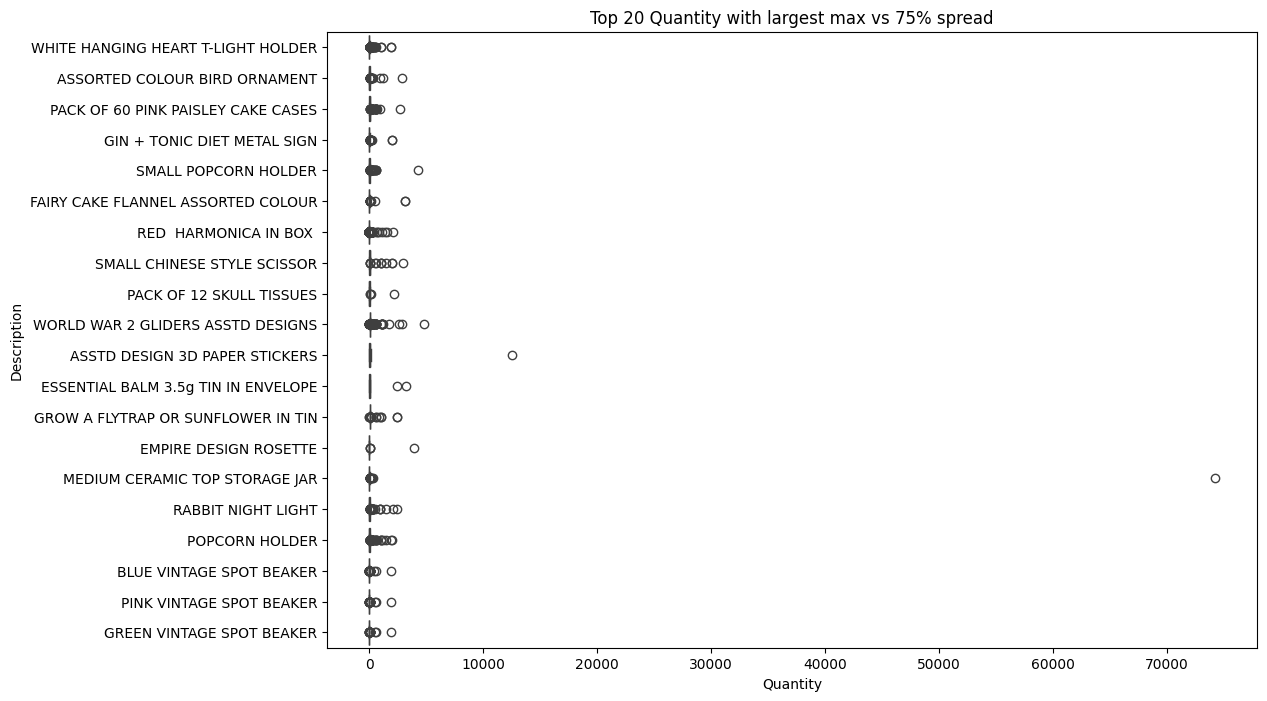

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

spread = df5.groupby('Description').apply(lambda x: x['Quantity'].max() - x['Quantity'].quantile(0.75))
top_products = spread.sort_values(ascending=False).head(20).index

plt.figure(figsize=(12,8))
sns.boxplot(x='Quantity', y='Description', data=df5[df5['Description'].isin(top_products)])
plt.title('Top 20 Quantity with largest max vs 75% spread')
plt.show()


### Feature Engineering

- Creating Revenue column

In [25]:
df5['Revenue'] = df5['Quantity'] * df5['UnitPrice']

In [26]:
df5.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [27]:
df5['Revenue'].describe()

,Revenue
count,392732.000000
mean,22.629195
std,311.083465
min,0.000000
25%,4.950000
50%,12.390000
75%,19.800000
max,168469.600000


## 2. EDA

##### Check top countries by Number of Orders

In [28]:
df5['Country'].value_counts().head(10).reset_index()

,Country,count
0,United Kingdom,349227
1,Germany,9027
2,France,8327
3,EIRE,7228
4,Spain,2480
5,Netherlands,2363
6,Belgium,2031
7,Switzerland,1842
8,Portugal,1453
9,Australia,1184


In [29]:
import plotly.express as px

top10 = df5['Country'].value_counts().head(10).reset_index()
top10.columns = ['Country', 'Count']

fig = px.pie(
    top10,
    names='Country',
    values='Count',
    title='Top Countries by Number of Orders',
    hole=0
)

fig.show()

##### Checking date range

In [30]:
df5['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [31]:
df5['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

- We have data from December 2010 to December 2011 (Only 1 year data)

### Univariate Analysis

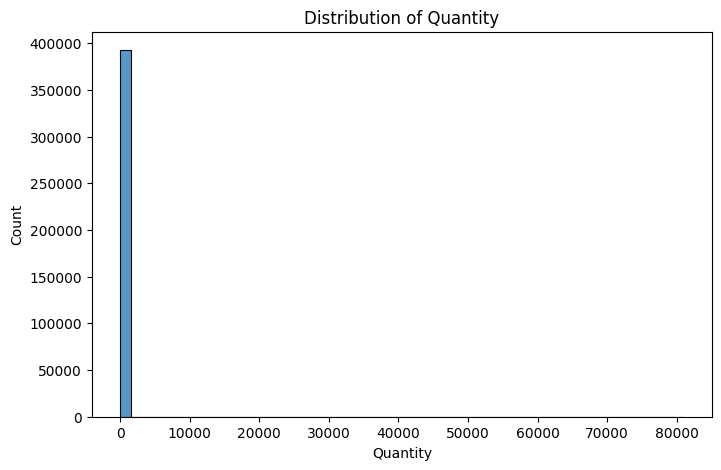

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(df5['Quantity'],bins=50)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Count")
plt.show()


- Most of people go with Quantity less than 2000.
- There are outliers in Quantity value but that can be bulk orders.

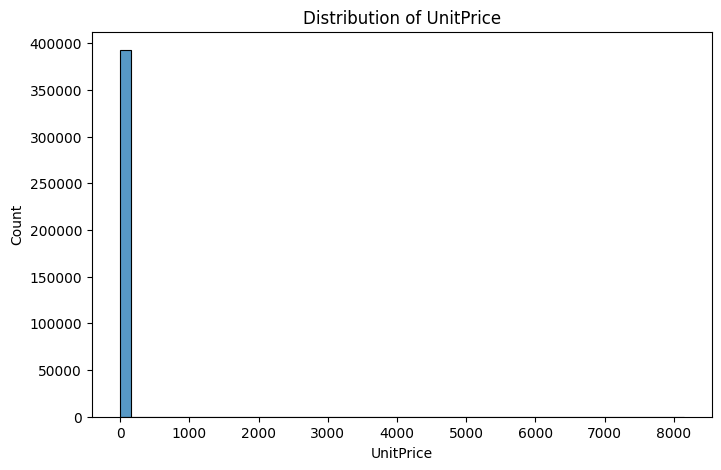

In [33]:
plt.figure(figsize=(8,5))
sns.histplot(df5['UnitPrice'], bins=50)
plt.title("Distribution of UnitPrice")
plt.xlabel("UnitPrice")
plt.ylabel("Count")
plt.show()

- UnitPrice is heavily right-skewed, dominated by low-cost items, with a few high-price products creating a long tail.

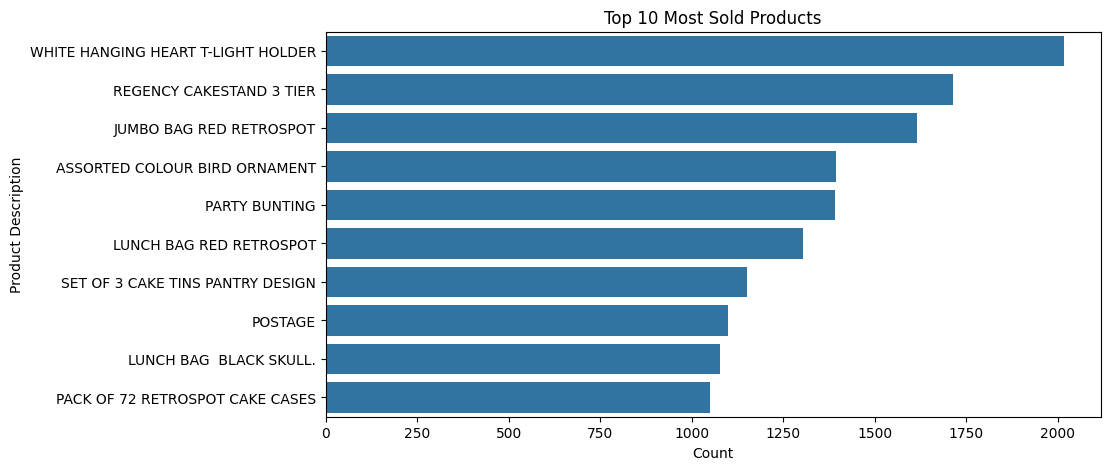

In [34]:
df5['Description']=df5['Description'].str.strip()
top_products = df5['Description'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Most Sold Products")
plt.xlabel("Count")
plt.ylabel("Product Description")
plt.show()


- The best-selling products are mostly cheap decorative and household items. The WHITE HANGING HEART T-LIGHT HOLDER is the most popular by far.

In [35]:
df5['Revenue'].describe()

,Revenue
count,392732.000000
mean,22.629195
std,311.083465
min,0.000000
25%,4.950000
50%,12.390000
75%,19.800000
max,168469.600000


## Bivariate Analysis

<Axes: >

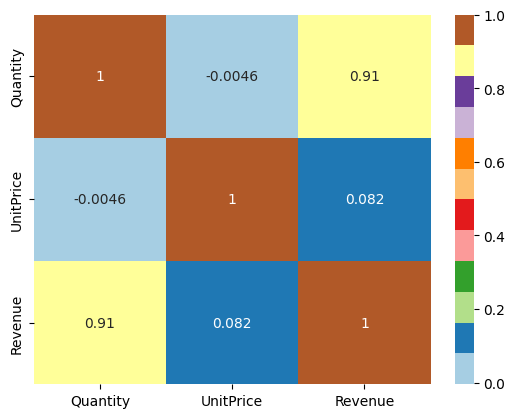

In [36]:
sns.heatmap(df5[['Quantity','UnitPrice','Revenue']].corr(numeric_only=True),cmap='Paired',annot=True)

- As expected, both Quantity and UnitPrice show a positive correlation with Revenue.
- There is almost no relationship between (Quantity and UnitPrice) and (Revenue and UnitPrice), as the correlation value is very close to zero.




##### Sales per month

In [37]:
df5['Month']=pd.to_datetime(df5['InvoiceDate']).dt.to_period('M')

In [38]:
df5.groupby('Month')['Revenue'].sum()

,Revenue
Month,
2010-12,570422.730
2011-01,568101.310
2011-02,446084.920
2011-03,594081.760
2011-04,468374.331
2011-05,677355.150
2011-06,660046.050
2011-07,598962.901
2011-08,644051.040


Text(0.5, 1.0, 'Sales per Month')

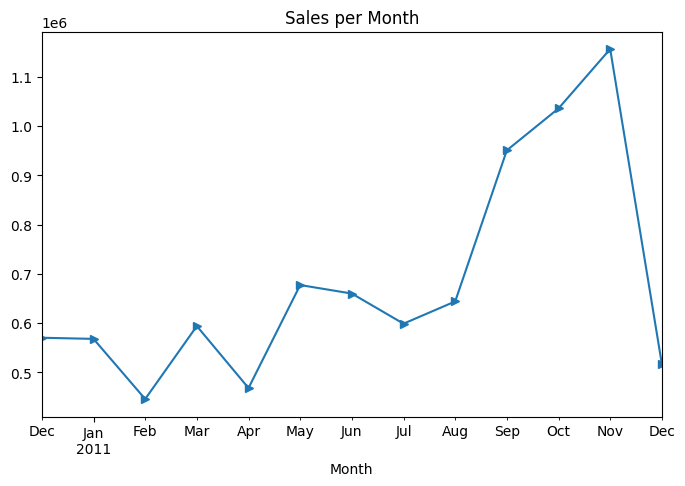

In [39]:
plt.figure(figsize=(8,5))
df5.groupby('Month')['Revenue'].sum().plot(marker='>')
plt.title('Sales per Month')

- The period from September to November 2011 recorded the highest sales, with November being the peak month.
- The lowest sales were observed in February and April.
- December also shows low sales, but the data for December is limited.

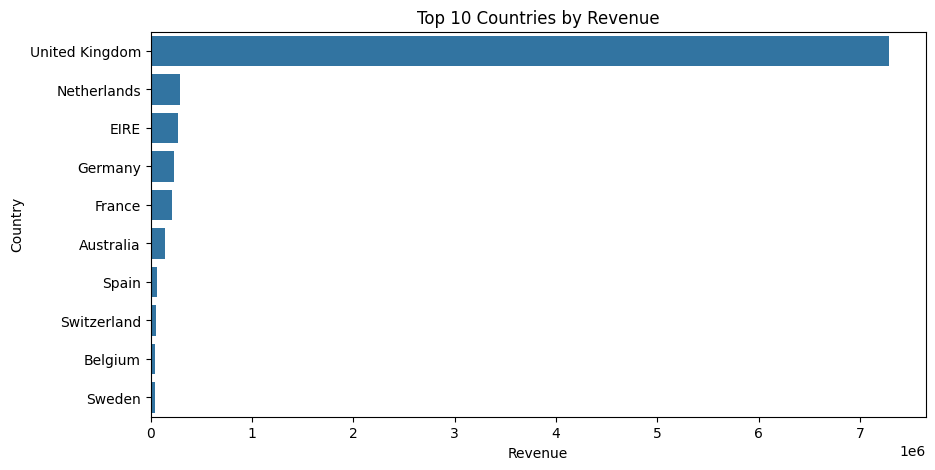

In [40]:
country_sales = df5.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()

- United Kingdom dominates the revenue, generating far more than all other countries combined.

- The next tier (EIRE, Germany, France, Netherlands) has moderate revenue, but each is much smaller than the UK.
- The remaining countries (Australia, Switzerland, Spain, Belgium, Sweden) contribute very little in comparison.

In [41]:
df5['Date'] = df5['InvoiceDate'].dt.date

daily_sales = df5.groupby('Date')['Revenue'].sum()


#### Revenue Trend (Moving Average)

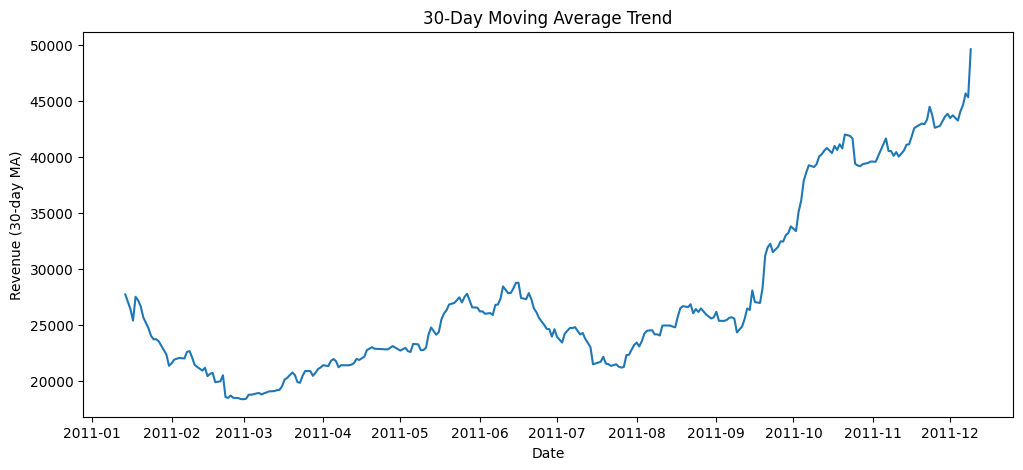

In [42]:
trend = daily_sales.rolling(window=30).mean()

plt.figure(figsize=(12,5))
trend.plot()
plt.title("30-Day Moving Average Trend")
plt.xlabel("Date")
plt.ylabel("Revenue (30-day MA)")
plt.show()

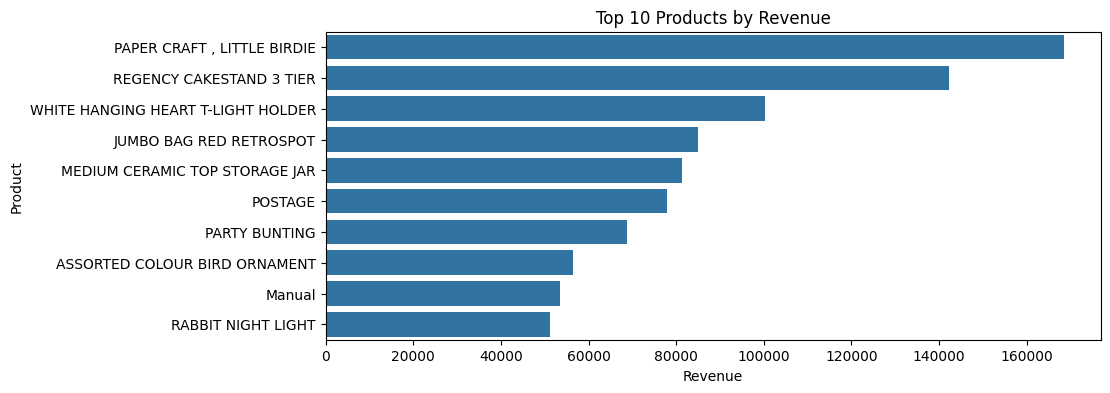

In [43]:
top_products = df5.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot(y=top_products.index, x=top_products.values)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()


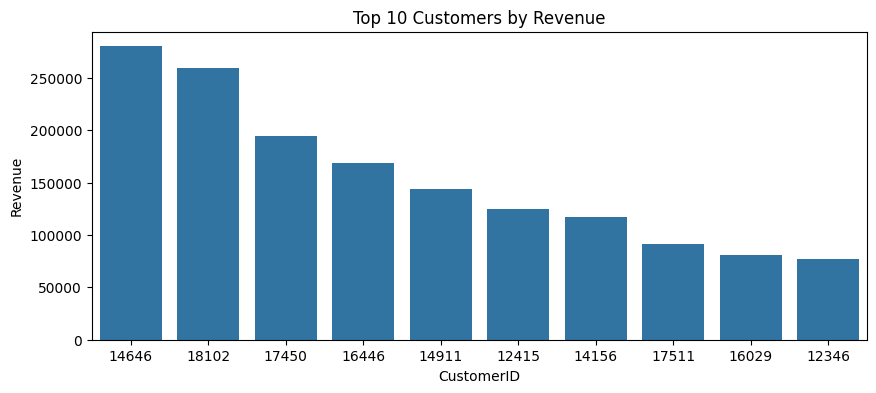

In [44]:
top_customers = df5.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
sns.barplot(x=top_customers.index.astype(str), y=top_customers.values)
plt.title("Top 10 Customers by Revenue")
plt.xlabel("CustomerID")
plt.ylabel("Revenue")
plt.show()

- The bar plot clearly shows that the customer with ID 14646 generates the highest revenue for the company.

## RFM

In [45]:
df5

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Month,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12,2011-12-09


In [46]:
import datetime as dt

In [47]:
ref_date=df5['InvoiceDate'].max() + dt.timedelta(days=1)

#RFM aggregation
rfm=df5.groupby('CustomerID').agg({
    'InvoiceDate':lambda x:(ref_date - x.max()).days,
    'InvoiceNo':'nunique',
    'Revenue':'sum'
})

rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Revenue':'Monetary'},inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [48]:
#RFM
import numpy as np

rfm['R_score']=pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
).astype(int)

rfm['M_score'] = pd.qcut(
    rfm['Monetary'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
).astype(int)

In [49]:
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,5,115
12347,2,7,4310.00,5,5,5,555
12348,75,4,1797.24,2,4,4,244
12349,19,1,1757.55,4,1,4,414
12350,310,1,334.40,1,1,2,112


In [50]:
def segment_customer(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 4 and f >= 3:
        return 'Loyal Customers'
    elif r >= 3 and f >= 3:
        return 'Potential Loyalists'
    elif r >= 2 and f >= 2:
        return 'Needs Attention'
    elif r == 1 and f == 1:
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,115,Lost Customers
12347,2,7,4310.00,5,5,5,555,Champions
12348,75,4,1797.24,2,4,4,244,Needs Attention
12349,19,1,1757.55,4,1,4,414,Others
12350,310,1,334.40,1,1,2,112,Lost Customers


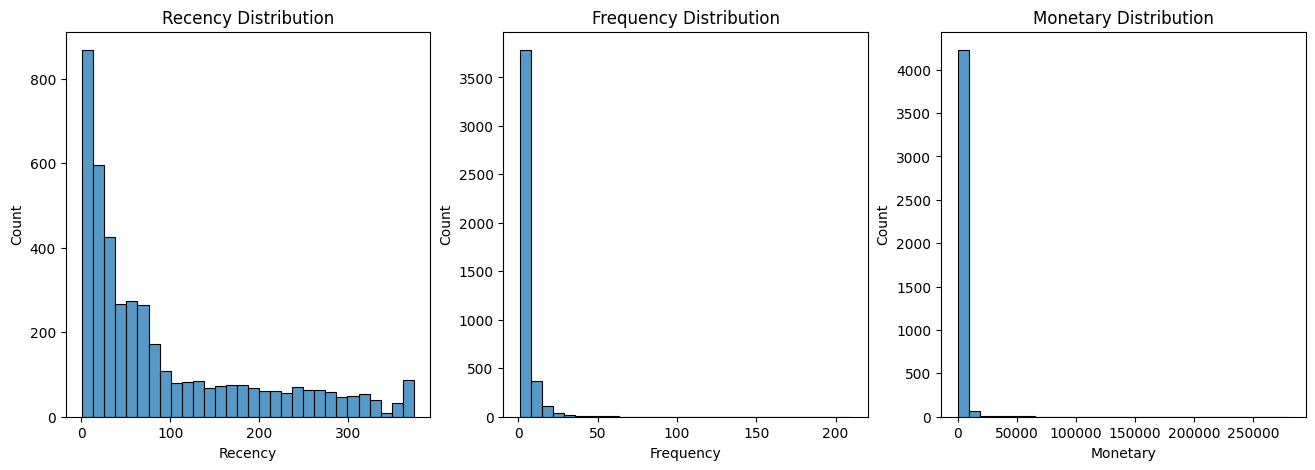

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30)
plt.title("Recency Distribution")

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title("Frequency Distribution")

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title("Monetary Distribution")

plt.show()


- Most customers recency is less under 100 days
- Most of customers frequency is under 50
- Most of customers monetary is under 25000

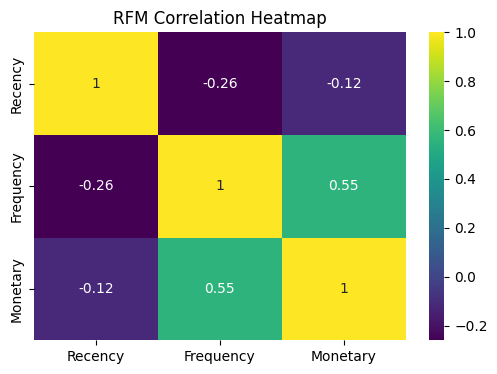

In [52]:
plt.figure(figsize=(6,4))
sns.heatmap(rfm[['Recency','Frequency','Monetary']].corr(), annot=True, cmap='viridis')
plt.title("RFM Correlation Heatmap")
plt.show()


- As frequency increases Monetary increases, as expected.
- As Recency increases the Monetary and frequency decreases.

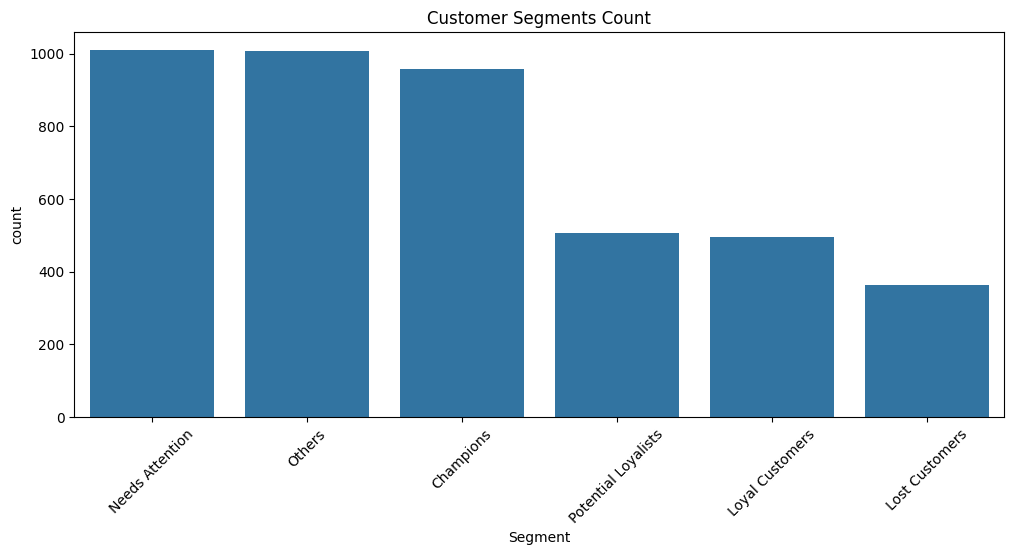

In [53]:
plt.figure(figsize=(12,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Customer Segments Count")
plt.show()

- Most of customers needs attention

## KMEANS CUSTOMER SEGMENTATION

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
rfm_kmeans=rfm[['Recency','Frequency','Monetary']]

##### Scaling the data to perform kmeans

In [56]:
scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_kmeans)

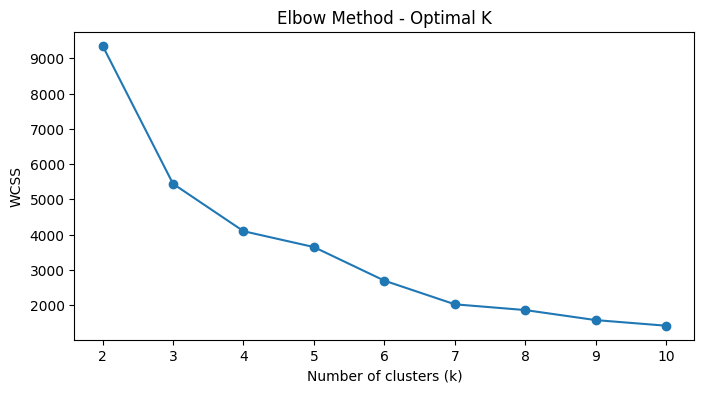

In [57]:
wcss = []
K=range(2,11)

for k in K:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(8,4))
plt.plot(K,wcss,marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.show()

In [58]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    sil = silhouette_score(rfm_scaled, labels)
    print(f"k={k} → silhouette score = {sil:.4f}")

k=2 → silhouette score = 0.5606
k=3 → silhouette score = 0.5944
k=4 → silhouette score = 0.6161
k=5 → silhouette score = 0.4364
k=6 → silhouette score = 0.4829
k=7 → silhouette score = 0.5162
k=8 → silhouette score = 0.5169
k=9 → silhouette score = 0.4919
k=10 → silhouette score = 0.4838


- choosen the k=4 as it gives highest silhouette score

#### Train Final KMeans Model

In [59]:
kmeans=KMeans(n_clusters=4,random_state=42)
rfm['Cluster']=kmeans.fit_predict(rfm_scaled)

In [60]:
cluster_summary=rfm.groupby("Cluster")[['Recency','Frequency','Monetary']].mean()

In [61]:
cluster_summary

,Recency,Frequency,Monetary
Cluster,,,
0,15.672986,22.047393,12435.086682
1,248.564030,1.551789,476.330547
2,7.384615,82.692308,127187.959231
3,43.910580,3.655748,1344.284013


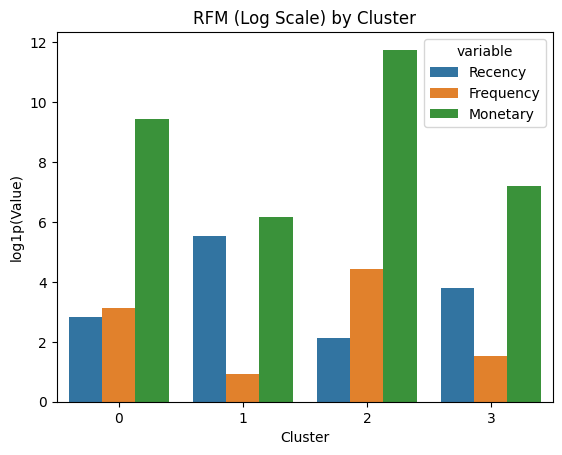

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

df_m = np.log1p(cluster_summary).reset_index().melt(id_vars="Cluster")
sns.barplot(df_m, x="Cluster", y="value", hue="variable")

plt.title('RFM (Log Scale) by Cluster')
plt.ylabel('log1p(Value)')
plt.show()

- Above graph clearly shows Highest priority customers for this business are in 2nd cluster with lowest recency,highest(Frequency and monetary) followed by 0
- cluster 1 has high recency and lowest monetary frequency they like one time buyers
- cluster 1 customers needs attention

<Axes: xlabel='Cluster', ylabel='count'>

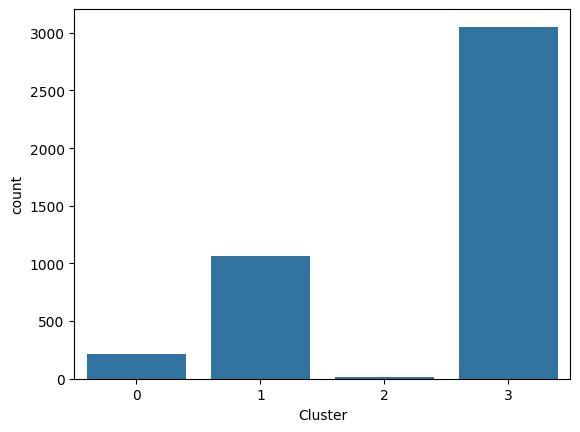

In [63]:
sns.countplot(data=rfm,x='Cluster')

- from the clustering high number of cutomers fall in 3 cluster followed by 1
- all though thier is low customer count in cluster 2 and 0 they the most loyal customers for this business best in rec,mon,freq

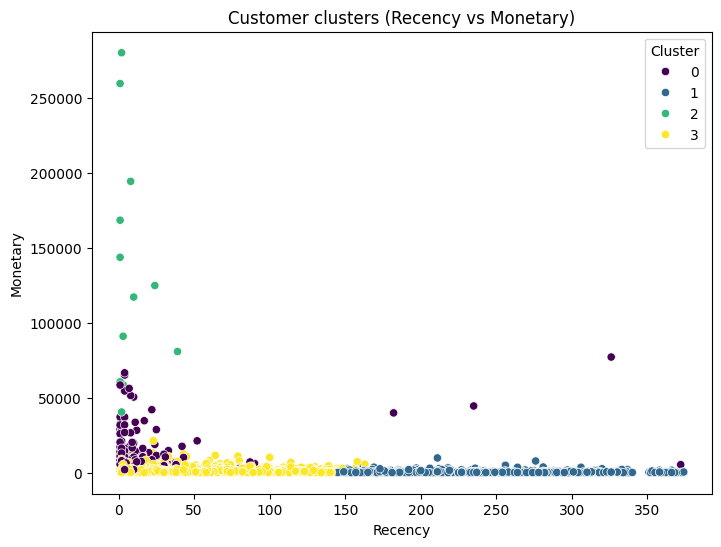

In [64]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='viridis'
)
plt.title('Customer clusters (Recency vs Monetary)')
plt.show()

- Customers with high monetary and lower recency ex.(cluster 0,2,3 and some of 1) important for this business

In [65]:
import plotly.express as px

fig = px.scatter_3d(
    rfm,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    title='Interactive 3D Scatter Plot of RFM Clusters',
    opacity=0.7,
    height=600
)

fig.update_traces(marker=dict(size=4))
fig.show()


In [66]:
df5.to_csv('filtered_online_retail_data1.csv')